# Template para pré-processamento

## Importanto bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

%matplotlib inline

In [2]:
# deixar a pasta scripts vizivel no notebook
%load_ext autoreload
%autoreload 2

import sys
import os

module_path = os.path.abspath(os.path.join('..', 'pyscripts'))
if module_path not in sys.path :
    sys.path.append(module_path)

In [3]:
# import module from scripts folder
import process_data

## Pré-processamento dos dados

In [4]:
## import dataset from ../data
dataFolder = os.path.join('..','Simulations')

# the same file will be searching
mainFile = 'packet_breakdown.txt' 

simulationFolders = ["PA", "PB", "CL2", "CL4", "CLBinomial"]

dfData = pd.DataFrame()

for folder in simulationFolders:
    data_file = os.path.join(dataFolder,folder,mainFile)
#     df = process_data.parser_main_table(data_file)
    df = process_data.parser_main_table(data_file)
    df['Simulation'] = folder
    dfData = dfData.append(df,ignore_index=True)

del df

In [5]:
dfData.columns

Index(['info_0', 'info_1', 'info_2', 'Failed, buffer overflow',
       'Failed, busy channel', 'Failed, no ack', 'Success, first try',
       'Success, not first try', 'Simulation'],
      dtype='object')

In [6]:
dfData.head()

,info_0,info_1,info_2,"Failed, buffer overflow","Failed, busy channel","Failed, no ack","Success, first try","Success, not first try",Simulation
0,setRateHigh,InterfModel=0,node=1,0,0.03636,0.02924,0.73991,0.19448,PA
1,setRateHigh,InterfModel=0,node=2,0,0.03415,0.01313,0.76674,0.18598,PA
2,setRateHigh,InterfModel=0,node=3,0,0.02313,0.04063,0.75252,0.18372,PA
3,setRateHigh,InterfModel=0,node=4,0.12637,0.01254,0.01919,0.70874,0.13315,PA
4,setRateHigh,InterfModel=0,node=5,0.15026,0.01161,0.02518,0.70296,0.11,PA


### Certificar que os tipos de dados são apropriados

In [7]:
numericColumns = [
    'Failed, buffer overflow',
    'Failed, busy channel' ,
    'Failed, no ack',
    'Success, first try',
    'Success, not first try'
]

dfData[numericColumns] = dfData[numericColumns].astype('float')
dfData[numericColumns] *= 100

In [8]:
nodes_PT = { 
        'node=1': 'E-Punho',
        'node=2': 'D-Punho',
        'node=3': 'E-Tornozelo',
        'node=4': 'D-Tornozelo',
        'node=5': 'Peito',
        'node=0' : 'Cintura'
    }

nodes_ENG = { 
        'node=1': 'L-wrist',
        'node=2': 'R-wrist',
        'node=3': 'L-ankle',
        'node=4': 'R-ankle',
        'node=5': 'chest',
    }

def infer_node(value,mapper=nodes_PT):
    return mapper[value]

dfData['info_1'] = dfData['info_1'].apply(infer_node)

In [9]:
def clean_attr(str_value):
    index = str_value.find('=')
    if index >= 0 :
        return str_value[(index+1):]
    else:
        return str_value
    
def change_collisionModel_attr(str_value):
    
    index = clean_attr(str_value)
    
    if index == '1':
        return 'with interference' # 'with collision'
    else: # == 0
        return 'without interference' # 'without collision'
    
dfData['info_0'] = dfData['info_0'].apply(change_collisionModel_attr)

In [10]:
columnTranslate = {
    'info_0' : 'Modelo de colisão',
    'info_1' : 'Nó sensor',
    'info_2' : 'Repetição',
    'Failed, buffer overflow': 'Falha, estouro de buffer',
    'Failed, busy channel' : 'Falha, canal ocupado',
    'Failed, no ack': 'Falha, não recebimento ACK', 
    'Success, first try' : 'Sucesso, primeira tentativa',
    'Success, not first try' : 'Sucesso, retransmissão',
    'Simulation' : 'Simulação'
}

# columnTranslate = {
#     'info_0' : 'Collision model',
#     'info_1' : 'Node',
#     'info_2' : 'Repetition',
# }

dfData.rename(mapper=columnTranslate,axis='columns', inplace=True)

In [11]:
dfData.head()

,Modelo de colisão,Nó sensor,"Falha, estouro de buffer","Falha, canal ocupado","Falha, não recebimento ACK","Sucesso, primeira tentativa","Sucesso, retransmissão",Simulação
0,without interference,E-Punho,0.000,3.636,2.924,73.991,19.448,PA
1,without interference,D-Punho,0.000,3.415,1.313,76.674,18.598,PA
2,without interference,E-Tornozelo,0.000,2.313,4.063,75.252,18.372,PA
3,without interference,D-Tornozelo,12.637,1.254,1.919,70.874,13.315,PA
4,without interference,Peito,15.026,1.161,2.518,70.296,11.000,PA


In [12]:
dfData.dtypes

Modelo de colisão               object
Nó sensor                       object
Falha, estouro de buffer       float64
Falha, canal ocupado           float64
Falha, não recebimento ACK     float64
Sucesso, primeira tentativa    float64
Sucesso, retransmissão         float64
Simulação                       object
dtype: object

In [13]:
dfData.columns

Index(['Modelo de colisão', 'Nó sensor', 'Falha, estouro de buffer',
       'Falha, canal ocupado', 'Falha, não recebimento ACK',
       'Sucesso, primeira tentativa', 'Sucesso, retransmissão', 'Simulação'],
      dtype='object')

## Visualization 

In [14]:
# save images at ..
imageFolder = 'images'
isSaveImage = True

def save_image(img,file_name,file_ext='.png'):
    
    if not isSaveImage:
        return
    
    if not file_name.endswith(file_ext):
        file_name += file_ext
    
    if type(img) == sns.axisgrid.FacetGrid :
        img.savefig(os.path.join(imageFolder,file_name))

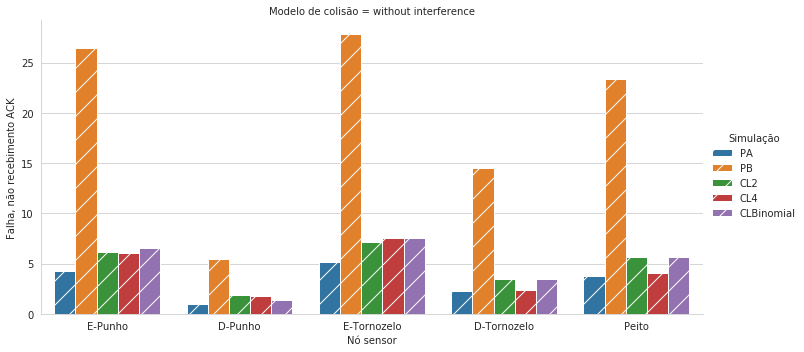

In [24]:
ax = g = sns.catplot(data=dfData,
                x='Nó sensor',
                y='Falha, não recebimento ACK',
                hue='Simulação',
                hue_order=["PA", "PB", "CL2", "CL4", "CLBinomial"],
                col='Modelo de colisão',
                kind='bar',
                height=5,
                aspect=2,
                ci=None,
                hatch='/'
               )

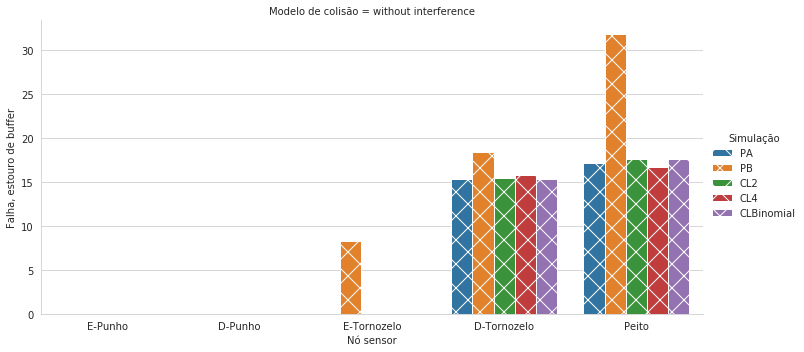

In [37]:
g = sns.catplot(data=dfData,
                x='Nó sensor',
                y='Falha, estouro de buffer',
                hue='Simulação',
                hue_order=["PA", "PB", "CL2", "CL4", "CLBinomial"],
                col='Modelo de colisão',
                kind='bar',
                height=5,
                aspect=2,
                ci=None,
                hatch='x'
               )

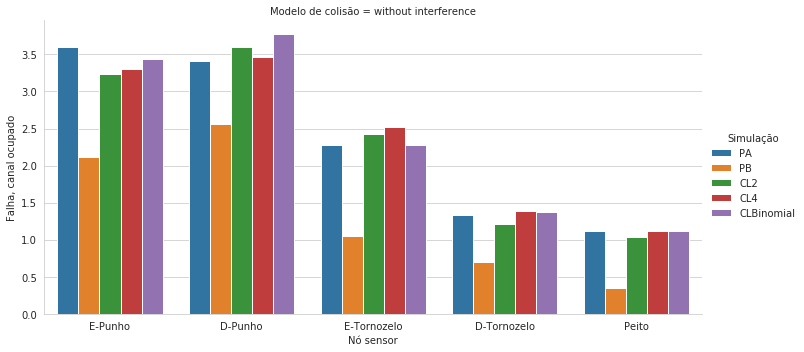

In [22]:
g = sns.catplot(data=dfData,
                x='Nó sensor',
                y='Falha, canal ocupado',
                hue='Simulação',
                hue_order=["PA", "PB", "CL2", "CL4", "CLBinomial"],
                col='Modelo de colisão',
                kind='bar',
                height=5,
                aspect=2,
                ci=None
               )